In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [2]:
cd GaitDatasetB-silh

/home/hexplex0xff/GAN/GaitDatasetB-silh


In [3]:
ls 002/bg-02

000/  018/  036/  054/  072/  090/  108/  126/  144/  162/  180/


In [4]:
import os

In [5]:
def preprocess(img):
    cnt, heir = cv2.findContours(img[:,:,0],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if (len(cnt)>0):
        x,y,w,h = cv2.boundingRect(cnt[0])
        temp = img[y:y+h, x:x+w, 0]
        w1 = (h*3)//4
        temp = cv2.copyMakeBorder(temp, 0,0, max(w1-w,0)//2, max(w1-w,0)//2, cv2.BORDER_CONSTANT, (0,0,0))
        return cv2.resize(temp, (120,160))
    else:
        return np.zeros((160,120))

In [6]:
for file in sorted(os.listdir(os.getcwd()+'/001/nm-01/000/')): 
    a = preprocess(cv2.imread('001/nm-01/000/'+file))
    cv2.imshow('frame',a)
    cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
def get_feature_vectors(imgs,k=10):
    G = np.vstack(tuple(preprocess(img).reshape(-1).astype(np.float64)/255. for img in imgs))
    avg = G.T.mean(axis=1)
    A = G.T-avg.reshape(-1,1)
    X = A.T@A / A.shape[1]
    eigvalue, eigvec = np.linalg.eigh(X)
    U = A@eigvec
    u = U/np.linalg.norm(U, axis=0)
    u_sorted = u[:,np.argsort(eigvalue)[::-1]]
    u_k = u_sorted[:,0:k]
    W = u_k.T@A
    A1 = u_k@W
    return W, A1, A, u_k, avg

In [8]:
W, A1, A, u_k, avg = get_feature_vectors((cv2.imread('001/bg-02/036/'+file) for file in sorted(os.listdir(os.getcwd()+'/001/bg-02/036'))))

In [9]:
def assert_images(X1,X, HEIGHT=160, WIDTH=120):
    for i in range(X1.shape[1]):
        cv2.imshow('frame',((X1).reshape(WIDTH, HEIGHT, -1)[:,:,i]))
        cv2.imshow('frame2',((X).reshape(WIDTH, HEIGHT, -1)[:,:,i]))
        cv2.waitKey(0)
    cv2.destroyAllWindows()

In [10]:
assert_images(A1+avg.reshape(-1,1),A+avg.reshape(-1,1),120,160)

In [11]:
class KMeans():
    def __init__(self, K = 16, debug=False):
        self.K = K
        self.debug = debug
        self.states = [[] for _ in range(self.K)]
        self.P = np.zeros((10,self.K))
    def fit(self,W):
        self.W = W
        for j in range(self.W.shape[1]):
            self.states[int(j*self.K/self.W.shape[1])].append(j)
        for i, state in enumerate(self.states):
            self.P[:,i] = self.W[:,state].mean(axis=1)
        self.converge()
    def converge(self):
        changes = 0
        while changes < 5 :
            prev_states = self.states
            for i, state in enumerate(self.states):
                self.P[:,i] = self.W[:,state].mean(axis=1)
            temp_states = []
            for i in range(self.K):
                temp_state = []
                for j in [max(0,i-1), min(i+1,self.K-1)]:
                    if i == j: continue
                    for state in self.states[j]:
                        if np.linalg.norm(self.W[:,state]-self.P[:,i]) <= np.linalg.norm(self.W[:,state]-self.P[:,j]):
                            if self.debug : print(i,j)
                            temp_state.append([j,state])
                temp_states.append(temp_state)
            for i, temp_state in enumerate(temp_states):
                temp_state.sort(key=lambda x : -x[1] if x[0]<i else x[0])
                for clst, frm in temp_state:
                    if clst<i:
                        if self.states[clst][-1] == frm and len(self.states[clst])>1:
                            self.states[clst].remove(frm)
                        else:
                            temp_states[i].remove([clst,frm])
                    else:
                        if self.states[clst][0] == frm and len(self.states[clst])>1:
                            self.states[clst].remove(frm)
                        else:
                            temp_states[i].remove([clst,frm])
            for i in range(len(self.states)):
                for _, x in temp_states[i]:
                    self.states[i].append(x)
                self.states[i].sort()
            if self.states != prev_states:
                changes = 0
            else:
                changes += 1
    def predict(self, W_t):
        MV = np.array(tuple(np.linalg.norm(W_t - self.P[:,i:i+1],axis=0) for i in range(self.K)))
        MV = 1 - MV / MV.max(axis=0)
        return MV

In [12]:
kmeans = KMeans(K=16,debug=True)

In [13]:
kmeans.fit(W)
kmeans.states

1 2
3 2
3 4
4 5
5 6
6 5
6 7
7 6
10 11
11 12
12 13
13 12
14 15
3 4
6 7
7 8
10 11
10 11
11 10
11 10
3 4
6 7
7 6
7 8
8 9
11 10
11 10
3 4
6 7
7 6
7 8
8 9
9 10
10 11
11 10
11 10
6 5
6 7
7 6
7 8
10 11
11 10


[[0, 1, 2, 3, 4, 5, 6],
 [7, 8, 9, 10, 11, 12, 13],
 [14, 15, 16, 17, 18],
 [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32],
 [33, 34, 35, 36, 37, 38],
 [39, 40, 41],
 [42, 43, 44, 45, 46, 47, 48, 49, 50, 50, 51, 52, 53, 54],
 [55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64],
 [65, 66, 67, 68, 69, 70, 71, 72, 73],
 [64, 64, 64, 74, 75, 76, 77],
 [78, 79, 80, 81, 82, 83],
 [84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95, 96],
 [97, 98, 99, 100, 101]]

In [14]:
test_imgs = (cv2.imread('001/nm-01/036/'+file) for file in sorted(os.listdir(os.getcwd()+'/001/nm-01/036')))

In [15]:
W_t, A1_t , A_t, _, avg_t = get_feature_vectors(test_imgs)

In [16]:
assert_images(A1_t+avg_t.reshape(-1,1), A_t+avg_t.reshape(-1,1), 120, 160)

In [17]:
def graph_sort(k_means, W_i,plot=False, A_i=None, avg_i=None):
    if plot:
        if (A_i is None) or (avg_i is None):
            raise Exception('For plot both A_i and avg_i must be passed')
    E = k_means.predict(W_i)
    V = np.zeros((E.shape[0]*E.shape[1], E.shape[0]*E.shape[1]))
    decode = lambda x,k : (x%k,x//k)
    encode = lambda i,j,k: j*k + i
    for cnt in range(V.shape[0]-E.shape[0]):
        i,j = decode(cnt, E.shape[0])
        for pos in [(i,j+1),((i+1)%E.shape[0],j+1)]:
            V[cnt,encode(*pos, E.shape[0])] = 1    # if V[x][y] == 1 then x->y only
    PV = np.zeros_like(E)
    for curr in range(V.shape[0]):
        maxx = 0
        for prev in np.where(V[:,curr]==1)[0]:
            temp = PV[decode(prev,E.shape[0])]
            if temp>maxx:
                maxx = temp
        PV[decode(curr,E.shape[0])] = maxx + E[decode(curr,E.shape[0])]
    term_state = (np.argmax(PV[:,-1]),E.shape[1]-1)
    test_states = []
    test_states.append(term_state[0])
    prevs = np.where(V[:,encode(*term_state,E.shape[0])]==1)[0]
    while len(prevs)>0:
        maxx = 0
        pos = 0
        for prev in prevs:
            if maxx < PV[decode(prev,E.shape[0])]:
                maxx = PV[decode(prev,E.shape[0])]
                pos = prev
        term_state = decode(pos,E.shape[0])
        test_states.append(term_state[0])
        prevs = np.where(V[:,encode(*term_state,E.shape[0])]==1)[0]
    test_states = np.asarray(test_states[::-1])
    if plot:
        cols = 10
        rows = (test_states.shape[0]//cols + (1 if test_states.shape[0]%cols>0 else 0))
        fig = plt.figure(figsize=(30,40))
        imgs = (A_i[:,:]+avg_i.reshape(-1,1)).reshape(160,120,-1)
        for i in range(1 , test_states.shape[0]+1):
            ax = fig.add_subplot(rows, cols, i)
            ax.set_title('key_pose-'+str(test_states[i-1]))
            plt.imshow(imgs[:,:,i-1],cmap='gray')
        plt.show()
    return test_states

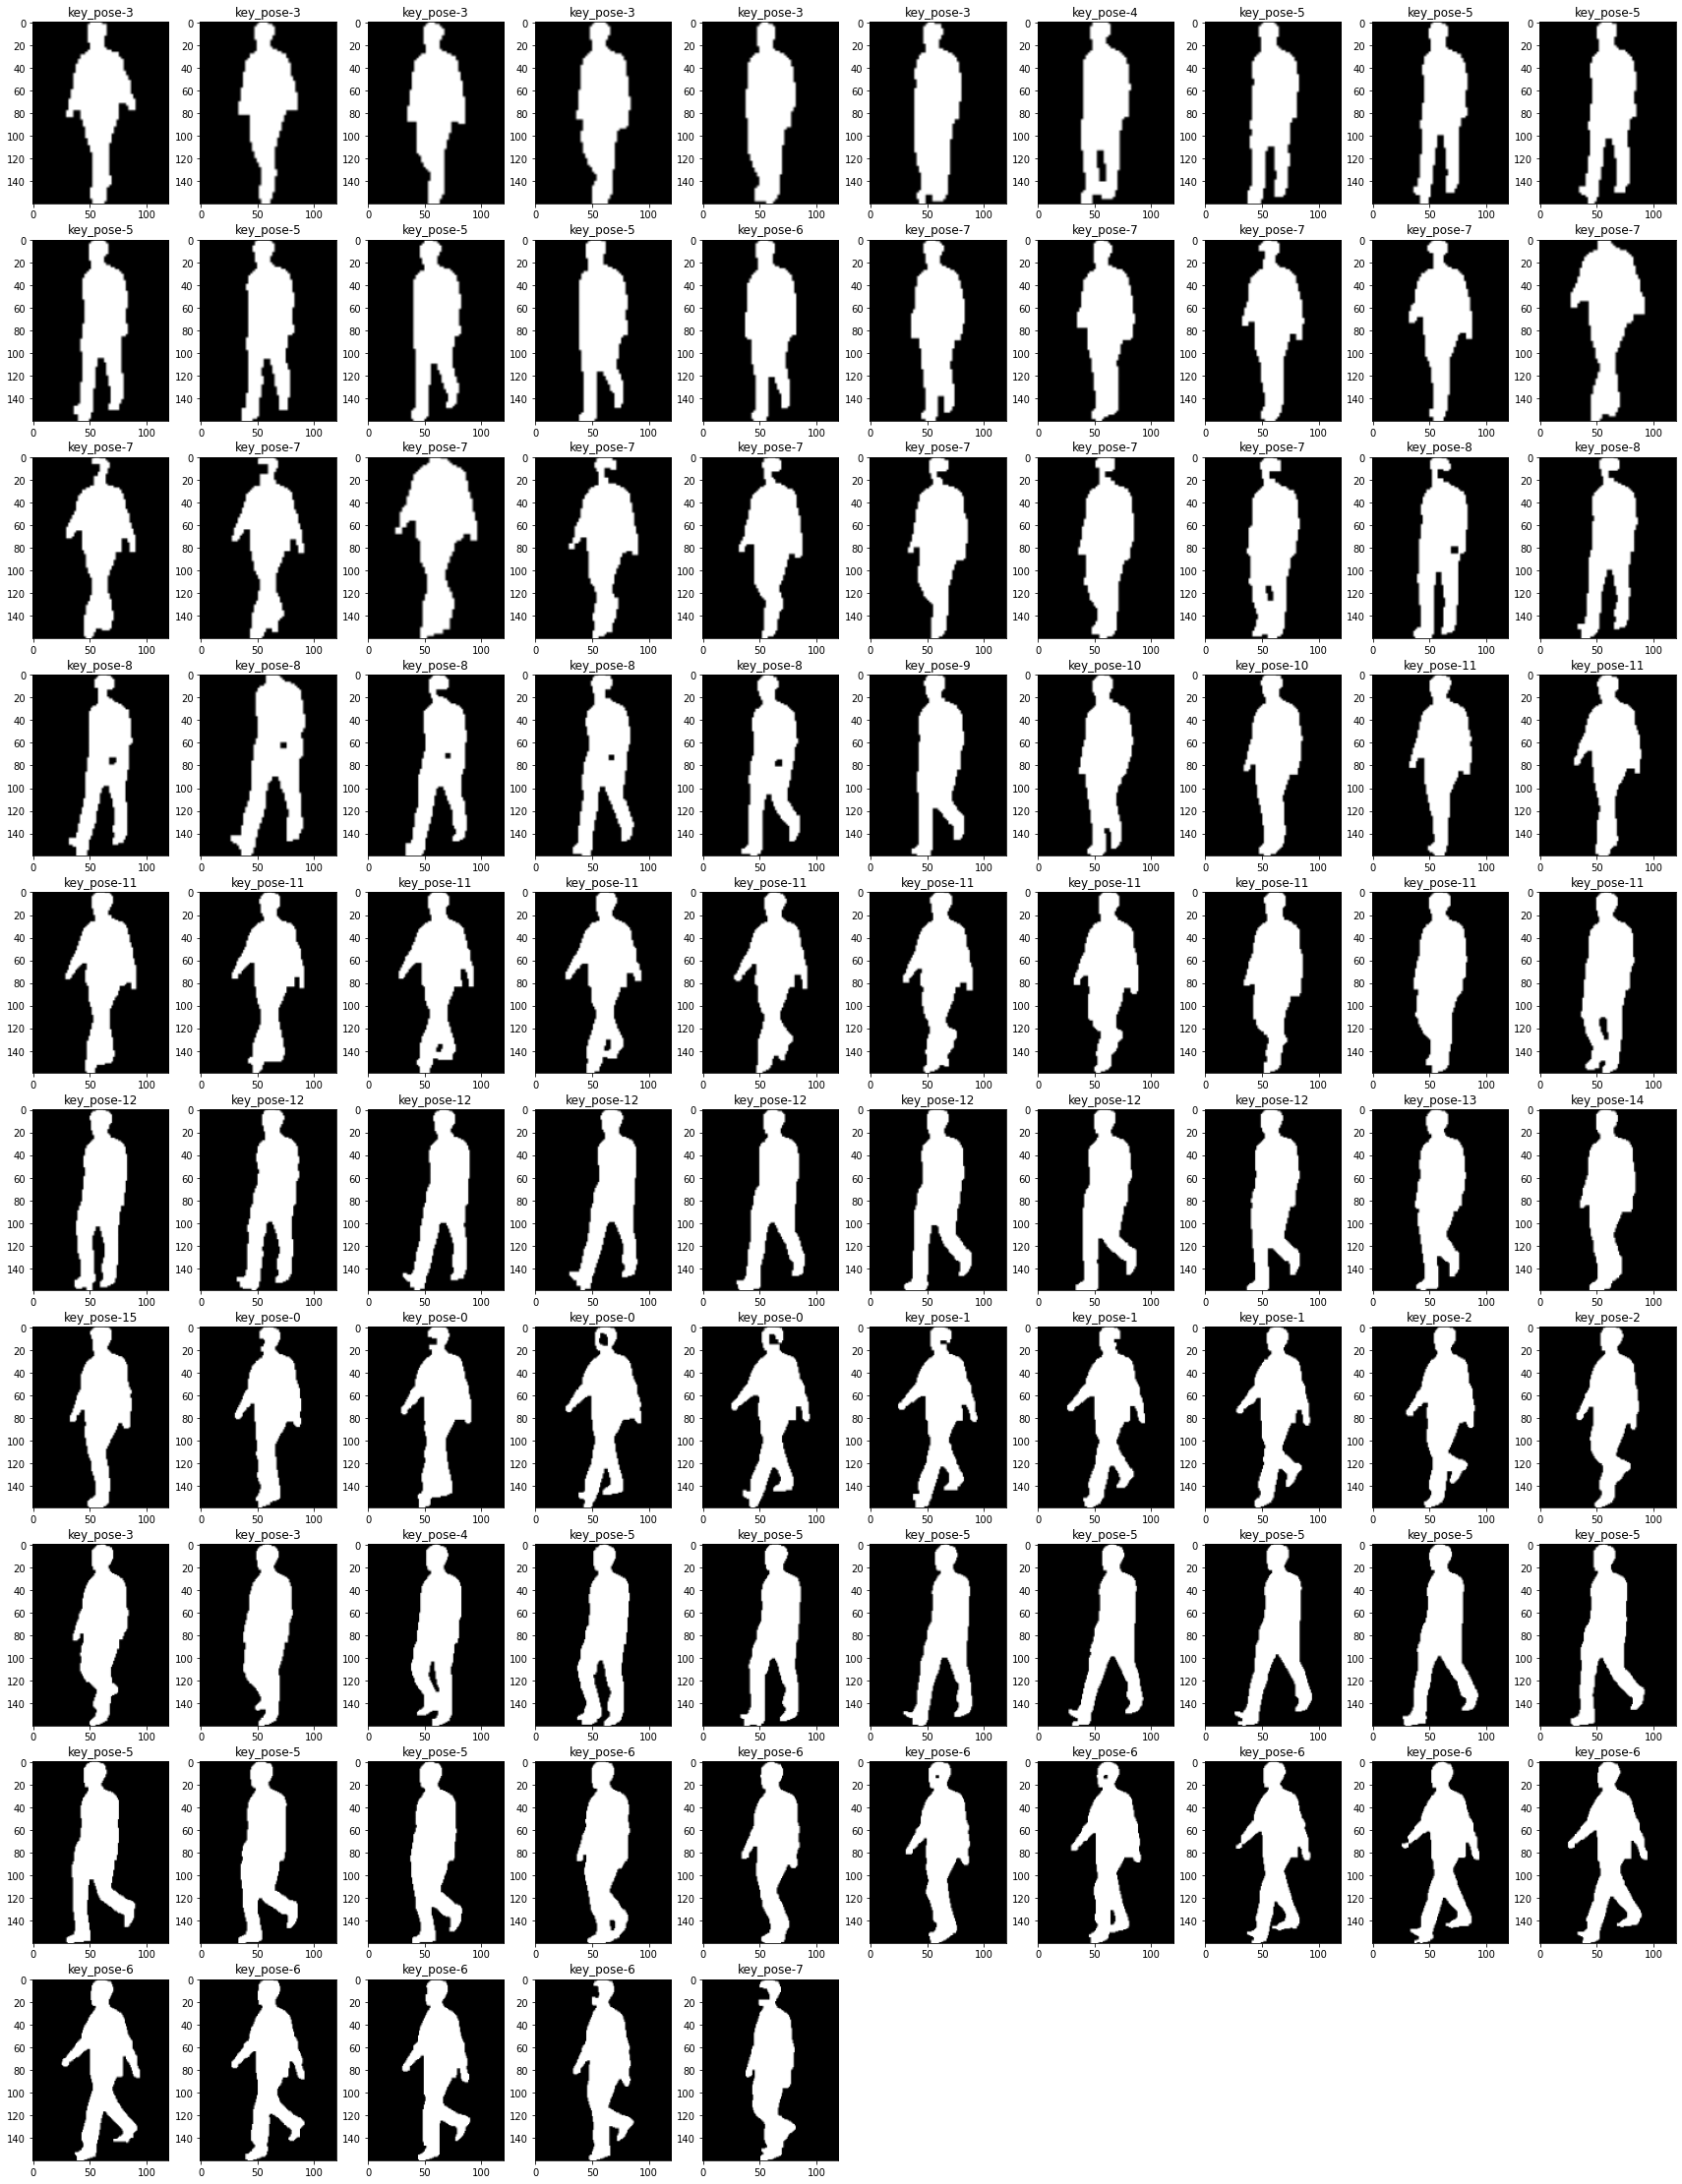

In [18]:
key_pose = graph_sort(kmeans,W_t,True,A_t,avg_t)

In [19]:
def display_array(imgs):
    sml_axis = np.argmin(imgs.shape)
    if sml_axis == 0: imgin = lambda x,i : x[i,:,:]
    elif sml_axis == 2: imgin = lambda x,i : x[:,:,i]
    else: imgin = lambda x,i : x[:,i,:]
    for i in range(imgs.shape[sml_axis]):
        cv2.imshow("asdf",imgin(imgs,i) )
        cv2.waitKey(0)
    cv2.destroyAllWindows()

In [20]:
display_array((A_t[:,:]+avg_t.reshape(-1,1)).reshape(160,120,-1))

In [21]:
def fetch_p_vec(key_poses,K,A_i,avg_i):
    PEI = []
    PK = []
    for i in range(K):
        indicies = np.where(key_poses==i)[0]
        PEI.append((A_i[:,indicies]+avg_i.reshape(-1,1)).reshape(160,120,-1).mean(axis=-1))
        PK.append(len(indicies)/len(key_poses))
    return np.asarray(PEI), np.asarray(PK)

In [22]:
PEI, PK = fetch_p_vec(key_pose, kmeans.K, A_t, avg_t)

In [23]:
display_array(PEI)

In [53]:
test_dataset = []
test_preproccessed = []
for i in range(10):
    direc = str(i+1)
    while len(direc)<3:
        direc = '0' + direc
    for folder in sorted(os.listdir(os.getcwd()+'/'+direc)):
        frames = []
        pro_frames = []
        for file in sorted(os.listdir(os.getcwd()+'/'+direc+'/'+folder+'/036')):
            frames.append(cv2.imread(direc+'/'+folder+'/036/'+file))
            pro_frames.append(preprocess(cv2.imread(direc+'/'+folder+'/036/'+file)))
        test_dataset.append(np.array(frames))
        test_preproccessed.append(np.moveaxis(np.array(pro_frames),0,-1))

In [54]:
PEI_test = []
PK_test = []
for test_data in test_dataset:
    W_t, A1_t , A_t, _, avg_t = get_feature_vectors(test_data)
    key_poses = graph_sort(kmeans, W_t)
    PEI_t, PK_t = fetch_p_vec(key_poses,kmeans.K, A_t, avg_t)
    PEI_test.append(PEI_t.reshape(-1,1))
    PK_test.append(PK_t)
PEI_test = np.array(PEI_test).reshape(-1, 160*120*kmeans.K)
PK_test = np.array(PK_test).reshape(-1, kmeans.K)

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  


In [55]:
PEI_mean = PEI_test.mean(axis=0)

In [56]:
G = PEI_test - PEI_mean.reshape(1,-1)

In [ ]:
from sklearn.utils.extmath import randomized_svd

V,s,U = randomized_svd(PEI_test,n_components=30)